In [47]:
# Load thư viện
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [48]:
# Kết nối Drive
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Study/Data_Analyst/3_Python/NgPhuongHuy_RFM_Project/ecommerce_retail.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Load dữ liệu file Excel
xls = pd.ExcelFile(path)

# Đọc từng sheet (theo tên hoặc số thứ tự)
ecommerce_retail = xls.parse(sheet_name='ecommerce_retail')
segmentation = xls.parse(sheet_name='Segmentation')

In [50]:
ecommerce_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [51]:
ecommerce_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [52]:
ecommerce_retail.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [53]:
print("Duplicates in ecommerce_retail:", ecommerce_retail.duplicated().sum())

Duplicates in ecommerce_retail: 5268


In [54]:
# CustomerID bị null
# Lý do: - Khách chưa đăng nhập, chưa đăng ký
#        - Giao dịch Offline
#        - Người mua không để lại thông tin
# Thiếu khoảng 25%, không thể phân tích được => Loại bỏ
ecommerce_retail = ecommerce_retail.dropna(subset=['CustomerID'])

# Ép CustomerID về kiểu string (để nhìn không bị có dấu .)
ecommerce_retail['CustomerID'] = ecommerce_retail['CustomerID'].astype(int).astype(str)

# Quantity hoặc UnitPrice <= 0
# Lý do: - Huỷ, trả hàng
# Không thể phân tích được => Loại bỏ
ecommerce_retail = ecommerce_retail[(ecommerce_retail['Quantity'] > 0) & (ecommerce_retail['UnitPrice'] > 0)]

# drop duplicates
ecommerce_retail = ecommerce_retail.drop_duplicates()

# Tạo TotalPrice = Quantity * UnitPrice
ecommerce_retail['TotalPrice'] = ecommerce_retail['Quantity'] * ecommerce_retail['UnitPrice']

# Reset index
ecommerce_retail.reset_index(drop=True, inplace=True)

In [55]:
# Gán ngày tham chiếu (ngày phân tích)
import datetime
snapshot_date = datetime.datetime(2011, 12, 31)

In [56]:
#Tính RFM metrics
rfm = ecommerce_retail.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

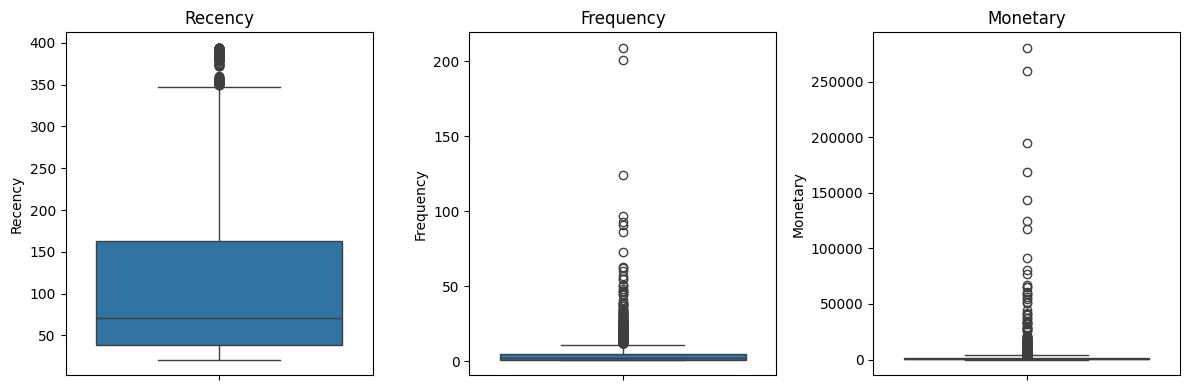

In [57]:
# Vẽ boxplot kiểm tra outlier
plt.figure(figsize=(12,4))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=rfm[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [58]:
# Recency: chỉ số phản ánh thực tế => giữ nguyên, không nên loại outlier
# Frequency: loại outlier để giảm ảnh hưởng của reseller
# Monetary: loại outlier để tránh bị bóp méo khi tính điểm
# Xử lý outliers cho Frequency và Monetary
f_max = rfm['Frequency'].quantile(0.995)
m_max = rfm['Monetary'].quantile(0.995)

rfm = rfm[(rfm['Frequency'] <= f_max) & (rfm['Monetary'] <= m_max)]

In [59]:
# Gán điểm R, F, M theo phân vị (1–5)
# Điểm càng cao càng tốt ⇒ Recency ngược
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# Gộp lại thành chuỗi RFM
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [60]:
# Chuyển cột "RFM Score" từ chuỗi về list:
segment_dict = {}
for _, row in segmentation.iterrows():
    scores = row['RFM Score'].replace(" ", "").split(',')
    for score in scores:
        segment_dict[score] = row['Segment']

In [61]:
#Gán segment cho từng khách hàng
rfm['Segment'] = rfm['RFM_Score'].map(segment_dict)
rfm

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
1,12347,23,7,4310.00,5,5,5,555,Champions
2,12348,96,4,1797.24,2,4,4,244,At Risk
3,12349,39,1,1757.55,4,1,4,414,Promising
4,12350,331,1,334.40,1,1,2,112,Lost customers
5,12352,57,8,2506.04,3,5,5,355,Loyal
...,...,...,...,...,...,...,...,...,...
4333,18280,298,1,180.60,1,2,1,121,Lost customers
4334,18281,201,1,80.82,1,2,1,121,Lost customers
4335,18282,28,2,178.05,5,3,1,531,Potential Loyalist
4336,18283,24,16,2045.53,5,5,5,555,Champions


In [67]:
#cài thư viện squarify
!pip install squarify

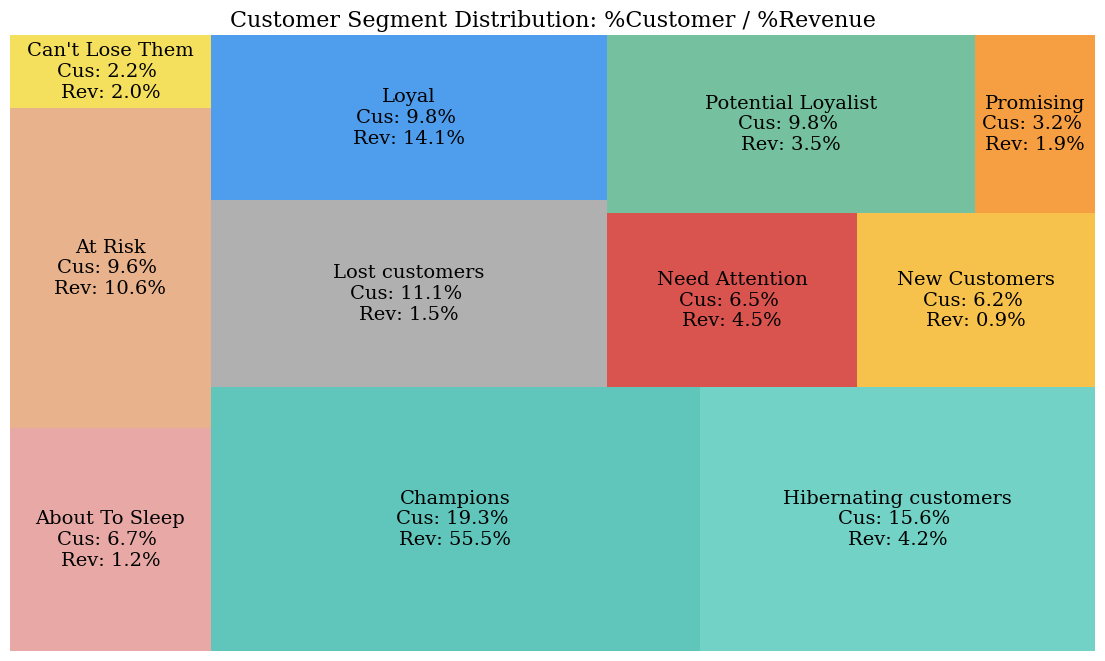

In [68]:
import squarify
# Tính tổng số khách hàng và tổng doanh thu toàn bộ
total_customers = rfm['CustomerID'].nunique()
total_revenue = rfm['Monetary'].sum()

# Gom nhóm theo Segment
rfm_segment_summary = rfm.groupby('Segment').agg({
    'CustomerID': 'nunique',
    'Monetary': 'sum'
}).reset_index()

# Tính % phân bổ khách hàng và % doanh thu
rfm_segment_summary['Customer_%'] = round(rfm_segment_summary['CustomerID'] / total_customers * 100, 1)
rfm_segment_summary['Revenue_%'] = round(rfm_segment_summary['Monetary'] / total_revenue * 100, 1)

# Tạo label hiển thị: tên segment + %Customer / %Revenue
rfm_segment_summary['Label'] = (
    rfm_segment_summary['Segment'] + '\n' +
    'Cus: '+ rfm_segment_summary['Customer_%'].astype(str) + '% ' + '\n' +
    'Rev: '+ rfm_segment_summary['Revenue_%'].astype(str) + '%'
)

# Gán màu cho từng segment
segment_colors = {
    'Champions': '#60C5BA',
    'Loyal': '#4F9DED',
    'Potential Loyalist': '#75C09E',
    'New Customers': '#F6C24C',
    'Promising': '#F59E42',
    'Need Attention': '#D9534F',
    'About To Sleep': '#E8A9A6',
    'Hibernating customers': '#71D2C5',
    'At Risk': '#E8B28C',
    "Can't Lose Them": '#F5E05E',
    'Lost customers': '#B0B0B0'
}
colors = [segment_colors[s] for s in rfm_segment_summary['Segment']]

# Vẽ Treemap
plt.figure(figsize=(14, 8))
squarify.plot(
    sizes=rfm_segment_summary['Customer_%'],
    label=rfm_segment_summary['Label'],
    color=colors,
    text_kwargs={'fontsize': 14, 'fontproperties': 'DejaVu Serif', 'weight': 'normal', 'color': 'black'}
)

plt.title(
    'Customer Segment Distribution: %Customer / %Revenue',
    fontsize=16,
    fontproperties='DejaVu Serif',
    weight='bold'
)

plt.title('Customer Segment Distribution: %Customer / %Revenue', fontsize=16)
plt.axis('off')
plt.show()

1. Phân tích hiện trạng công ty
  - Champions (19.3% khách, 55.5% doanh thu) là nhóm quan trọng nhất, mang lại hơn một nửa doanh thu dù chỉ chiếm chưa đến 1/5 khách.
  - Loyal (9.8%) và Potential Loyalist (9.8%) có tỉ trọng khách ổn nhưng đóng góp doanh thu thấp hơn nhiều so với Champions.
  - Lost customers (11.1%), Hibernating (15.6%), và At Risk (9.6%) cộng lại chiếm hơn 1/3 tổng khách hàng, nhưng hầu như không còn tạo ra doanh thu.
2. Gợi ý cho team Marketing

  Tăng CLV(Customer Lifetime Value) từ nhóm tốt nhất
  - Tập trung giữ chân Champions: Chăm sóc cá nhân hóa, thẻ thành viên VIP, ưu đãi riêng theo lịch sử chi tiêu.
  - Thúc đẩy nhóm Loyal → Champions, ví dụ bằng:
    - Ưu đãi nâng hạng.
    - Gửi email nhắc nhở họ đã gần đạt mức Champion.

  Kích hoạt nhóm rủi ro và ngủ quên
    - Hibernating, At Risk, About to Sleep:
      - Gửi thông điệp "Chúng tôi nhớ bạn", mã giảm giá quay lại.
      - Cảnh báo điểm thưởng sẽ hết hạn, hoặc quà tặng cho đơn tiếp theo.

  Xử lý nhóm Lost
    - Nếu khả thi: chiến dịch dành riêng cho khách hàng này
    - Nếu không: loại khỏi target ads để tiết kiệm ngân sách
3. Marketing & Sales nên ưu tiên chỉ số nào trong R - F - M?
  - Với Marketing: nên ưu tiên Recency (R) do các nhóm "Hibernating", "At Risk", "Lost" quá lớn → cần kích hoạt lại hoặc loại bỏ
  - Với Sales: nên ưu tiên Monetary (M) do doanh thu tập trung chủ yếu ở nhóm nhỏ (Champions) → cần khai thác thêm
